### Wstęp do Uczenia Maszynowego 
##### Laboratorium 13

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

### Zadanie 0
---
Wczytaj zbiór danych `pima.csv`.

a) Podziel zbiór danych losowo na część testową i treningową w stosunku 3:7.

b) Przygotuj dane (skalowanie). Dopasuj do zbioru treningowego sieć neuronową o zerowej liczbie warstw ukrytycj z logistyczną funkcją aktywacji. Następnie przygotuj model regresji logitycznej. Porównaj uzyskane współczynniki. 

c) Za pomocą funkcji `GridSearchCV` znajdź sieć dającą najlepsze rezultaty. Sieć może mieć 1, 2, 3 warstw ukrytych i każda z warstw może mieć rozmiar $p/2$, gdzie $p$ to liczba zmiennych objaśniających.

d) Porównaj miary AUC dla modeli z punktu b) i c).

In [19]:
pima = pd.read_csv("pima.csv")
y = pima.Outcome
X = pima.drop(["Outcome"], axis = 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 

In [21]:
scal = StandardScaler() #aby móc dopasować sieć neuronową, najpierw zeskalujemy dane
m1 = MLPClassifier(hidden_layer_sizes=(), solver='lbfgs',alpha=0,max_iter=1000) 

In [22]:
m2 = LogisticRegression(penalty = 'none',max_iter = 1000) #regresja logistyczna
pipe1 = Pipeline(steps = [("scal",scal),('m',m1)]) #pipeline ze skalowaniem i siecią neuronową
pipe2 = Pipeline(steps = [("scal",scal),('m',m2)]) #pipeline ze skalowaniem i regresją logistyczną
pipe1.fit(X_train,y_train) #fit_transform na StandardScalerze na X_train i fit na MLPClassifier na X_train i y_train
pipe2.fit(X_train,y_train) #fit_transform na StandardScalerze na X_train i fit na LogisticRegression na X_train i y_train
classifier1 = pipe1.named_steps['m'] #wchodzimy do MLPClassifiera w pipe1
print(classifier1.coefs_) # i wyciągamy jego współczynniki, ogólnie w MLPClassifierze są one przedstawiane w postaci
                          # listy array-ów, każdy array, odpowiada za przejście z jednej warstwy do drugiej,
                          #każdy array ma tyle wierszy ile jest zmiennych w warstwie z której wychodzimy,
                          #i tyle kolumn ile jest zmiennych w warstwie do której idziemy. Aby uzyskać w tym przejściu
                          #j-tą zmienną w nowej warstwie bierzemy zmienne ze starej, przemnażamy skalarnie 
                          #przez j-tą kolmnę arraya i obkładamy elementy wynikowego wektora funkcją aktywacji.
                          #w ostatnim kroku bierzemy zmienne z ostatniej warstwy ukrytej, mnożymy skalarnie
                          #przez ostatniego arraya i liczymy na tym sigmoid. 
classifier2 = pipe2.named_steps['m'] #wchodzimy do LogisticRegression w pipe1
print(classifier2.coef_) #i wyciągamy współczynniki regresji logistycznej.


[array([[ 0.32695504],
       [ 0.98498951],
       [-0.27202238],
       [ 0.06896422],
       [-0.04627334],
       [ 0.64929875],
       [ 0.31097517],
       [ 0.25182902]])]
[[ 0.32674497  0.98503456 -0.27199413  0.06887343 -0.04618997  0.64928963
   0.31098993  0.2515302 ]]


c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [23]:
p = X_train.shape[1] #liczba zmiennych objaśniających
p2 = int(p/2)
param_grid= {"m__hidden_layer_sizes":[(),(p2),(p),
                                      (p2,p2),(p2,p),(p,p2),(p,p),
                                      (p2,p2,p2),(p2,p2,p),(p2,p,p2),(p,p2,p2),
                                      (p,p,p2),(p,p2,p),(p2,p,p),(p,p,p)]} # ustalamy siatkę dla parametru 
                                                                           # hidden_layer_sizes, odwołujemy się
                                                                           # do elementu m pipeline'a (ponieważ
                                                                           # ten element zawiera w sobie ten
                                                                           # argument) i po podwójnym podkreślniku
                                                                           # wpisujemy nazwę argumentu 

search = GridSearchCV(pipe1,param_grid,n_jobs=-1) #definiujemy GridSearchCV, który przeszuka wszystkie pipeliny
                                                  #o sieciach, które są definiowane przez param_grida 
search.fit(X_train,y_train) #znajdujemy najlepszego pipeline'a
print(search.best_params_) 

{'m__hidden_layer_sizes': ()}


In [24]:
#d
search_probs = search.predict_proba(X_test)
search_probs = search_probs[:, 1]
print(roc_auc_score(y_test, search_probs)) 
log_probs = pipe2.predict_proba(X_test)
log_probs = log_probs[:, 1]
print(roc_auc_score(y_test, log_probs)) #porównujemy AUC najlepszego modelu z pipeline'a 
                                        #z AUC modelu regresji logistycznej, oczywiście to te same modele, więc
                                        #AUC jest takie samo.

0.8604938271604938
0.8604115226337448


### $k$-średnich *($k$-means)*

###### $K$ - średnich jest prostym podejściem do podziału zbioru danych na $k$ odrębnych, nienakładających się klastrów. Aby wykonać klastrowanie $k$ - średnich musimy najpierw określić żądaną liczbę klastrów $k$; następnie algorytm algorytm $k$-średnich przypisze każdą obserwację do dokładnie jednego z $k$ klastrów.


<img src="kmeans.png"  width="500"/>

###### *An Introduction to Statistical Learning with Applications in Python*


### Algorytm
1) *Ustalamy liczbę skupień*
2) *Ustalamy wstępne środki skupień*
3) *Obliczamy odległości obiektów (obserwacji) od środków skupień*
4) Przypisujemy obiekty do skupień
5) Ustalamy nowe środki skupień
6) Wykonujemy kroki 3), 4), 5) do czasu, aż warunek zatrzymania zostanie spełniony

<img src="centroids_iterations.webp"  width="600"/>

[*K-Means Clustering in Python: A Practical Guide*](https://realpython.com/k-means-clustering-python/)

### Dane

In [2]:
np.random.seed(0)
X = np.random.standard_normal((50, 2))
X[:25,0] += 3
X[:25,1] -= 4

<Axes: >

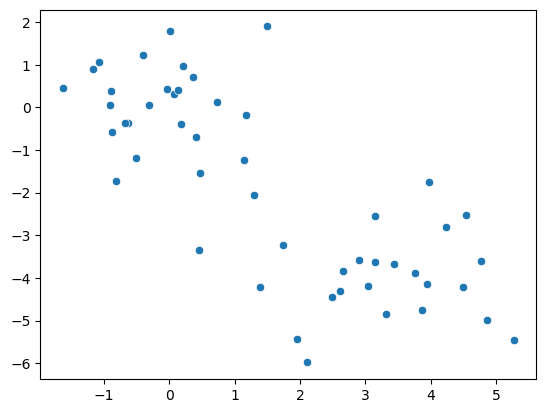

In [3]:
sns.scatterplot(x = X[:,0], y = X[:,1])

### Zadanie 1
---
Przygotuj model k-średnich dla liczby klastrów równej 2.
Użyj funkcji `KMeans()`. Przedstaw na wykresie przydział obserwacji do utworzonych skupień.

In [6]:
kmeans = KMeans(n_clusters = 2,
                random_state = 2,
                n_init = 20).fit(X)

c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'K-Means Clustering Results with K=2')

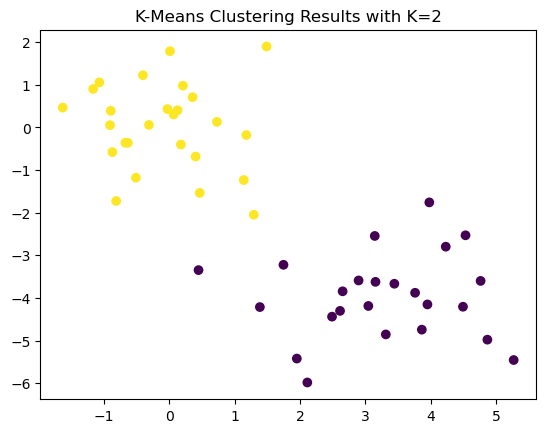

In [8]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c = kmeans.labels_)
plt.title("K-Means Clustering Results with K=2")

### Zadanie 2
---
Przygotuj model $k$-średnich dla k = 3. Narysuj wykres pokazujący przynależność obserwacji do utworzonych klastrów oraz zaznacz wyznaczone centroidy.

In [12]:
kmeans = KMeans(n_clusters=3, random_state=2, n_init=20).fit(X)

c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


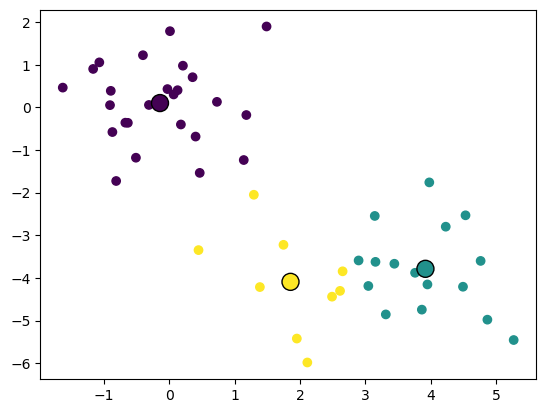

In [13]:
plt.scatter(X[:, 0], X[:, 1], c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = np.unique(kmeans.labels_), edgecolors="black", s=150)
    

### Zadanie 3
---
Za co jest odpowiedzialny parametr `n_init`? Porównaj model dla `n_init = 1` oraz `n_init = 20` używając `.interia_`.


In [14]:
kmeans1 = KMeans(n_clusters=3,
                random_state=3,
                n_init=1).fit(X)
kmeans20 = KMeans(n_clusters=3,
                  random_state=3,
                  n_init=20).fit(X)
kmeans1.inertia_, kmeans20.inertia_

c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(76.85131986999251, 75.06261242745384)

### Jak wybrać optymalne $k$?

### Zadanie 4
---
Rozważ $k$ z przedziału `range(1, 11)`, przyygotuj dla zadanego $k$ model i wylicz SSE. Przedstaw rezultaty na wykresie.

In [15]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
   }

sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\AnnA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows wi

Text(0, 0.5, 'SSE')

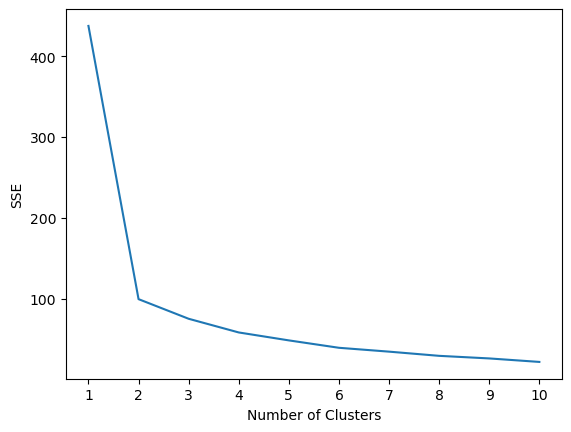

In [16]:
plt.plot(range(1,11),sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")